# Process CoMMpass Data

In the following notebook, we process input matrices for downstream machine learning applications.

We first calculate and visualize the per gene variability in the CoMMpass gene expression dataset.
We use Median Absolute Deviation ([MAD](https://en.wikipedia.org/wiki/median_absolute_deviation)) to measure gene expression variability.
We output this measurement to a file and recommend subsetting to 8,000 genes before input to machine learning models. This captures the majority of the variation in the data in raw gene space. This is a similar observation as seen previously in other experiments (see [Way et al. 2018](https://doi.org/10.1016/j.celrep.2018.03.046 "Machine Learning Detects Pan-cancer Ras Pathway Activation in The Cancer Genome Atlas") and [this discussion](https://github.com/cognoma/machine-learning/pull/18#issuecomment-236265506)).

We next subset the training and testing X matrices by these MAD genes and scale their measurements to a range of (0,1) by gene. We also process Y matrices into an `sklearn` ingestible format. Importantly, we process the dual Ras mutated samples (~3%) separately.

In [1]:
import os
import pandas as pd

from statsmodels.robust.scale import mad
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
num_genes = 8000

## Load and Subset Training X Matrix

Input to sklearn classifiers requires data to be in a bit different format than what was provided.

In [4]:
# Load the CoMMpass Training Data
file = os.path.join('data', 'raw', 'CoMMpass_train_set.csv')
train_df = pd.read_csv(file, index_col=0).drop("Location", axis='columns')
print(train_df.shape)

(58095, 706)


In [5]:
# Reorder genes based on MAD and retain higher variable genes
train_df = (
    train_df
    .assign(mad_genes = mad(train_df, axis=1))
    .sort_values(by='mad_genes', ascending=False)
    .drop('mad_genes', axis='columns')
)

# Remove duplicate ENSEMBL genes - retain genes with higher variability
train_df = train_df[~train_df.index.duplicated(keep='first')]

print(train_df.shape)
train_df.head(2)

(57981, 706)


,MMRF_1838_3_BM,MMRF_1201_4_BM,MMRF_2215_1_BM,MMRF_2728_1_BM,MMRF_1686_2_BM,MMRF_1331_1_BM,MMRF_2621_1_BM,MMRF_2437_1_BM,MMRF_1151_1_BM,MMRF_1286_1_BM,...,MMRF_1512_1_BM,MMRF_2538_1_BM,MMRF_2531_1_PB,MMRF_1640_1_BM,MMRF_1180_1_BM,MMRF_2335_1_BM,MMRF_2286_1_BM,MMRF_2229_1_BM,MMRF_2721_1_BM,MMRF_1157_1_BM
GENE_ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000166710,33040.90,14235.50,27410.00,24222.3,0.00,21585.00,19990.20,33409.60,8422.96,10193.30,...,26661.50,30116.70,24858.30,30336.30,16150.60,26628.60,46538.30,33028.30,11548.50,8063.93
ENSG00000105372,2756.69,2755.64,4459.72,9169.9,8584.99,6823.48,3515.27,1685.43,3667.90,2431.43,...,6283.13,1451.76,1433.19,6924.21,2841.25,7705.66,5577.79,3134.72,7297.68,1393.83


### Explore the variability of gene expression in the training set

In [6]:
# Get MAD genes again and sort
mad_genes = mad(train_df, axis=1)

mad_gene_df = (
    pd.DataFrame(mad_genes, index=train_df.index, columns=['mad_genes'])
    .sort_values(by='mad_genes', ascending=False)
)

# How many genes have no variance
(mad_gene_df['mad_genes'] == 0).value_counts()

True     32084
False    25897
Name: mad_genes, dtype: int64

In [7]:
# Remove genes lacking variance
mad_gene_df = mad_gene_df.query("mad_genes > 0")
print(mad_gene_df.shape)

(25897, 1)


In [8]:
mad_gene_df.head()

,mad_genes
GENE_ID,
ENSG00000166710,9673.312305
ENSG00000105372,2387.805003
ENSG00000177954,2369.657952
ENSG00000231500,2332.088812
ENSG00000133112,2233.792285


It looks like the highest variable gene is a large outlier
The gene is [B2M](http://useast.ensembl.org/Homo_sapiens/Gene/Summary?g=ENSG00000166710;r=15:44711477-44718877).

/home/greg/anaconda3/envs/multiple-myeloma-classifier/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


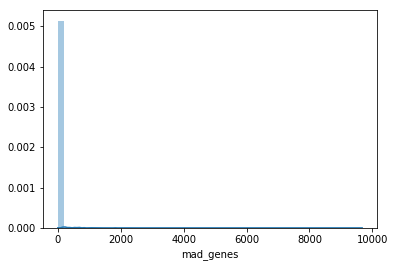

In [9]:
# Distribution of gene expression variability even after removing zeros
sns.distplot(mad_gene_df['mad_genes']);

/home/greg/anaconda3/envs/multiple-myeloma-classifier/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


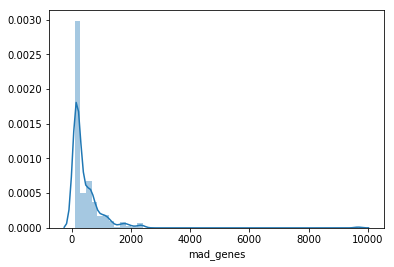

In [10]:
# Distribution of genes with high gene expression variability
sns.distplot(mad_gene_df.query("mad_genes > 100")['mad_genes']);

In [11]:
# Get the proportion of total MAD variance for each gene
total_mad = mad_gene_df['mad_genes'].sum()
mad_gene_df = (
    mad_gene_df
    .assign(variance_proportion = mad_gene_df['mad_genes'].cumsum() / total_mad)
)

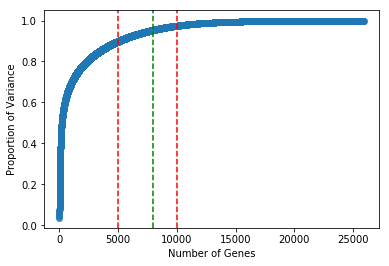

In [12]:
# Visualize the proportion of MAD variance against all non-zero genes
sns.regplot(x='index',
            y='variance_proportion',
            ci=None,
            fit_reg=False,
            data=mad_gene_df.reset_index().reset_index())
plt.xlabel('Number of Genes')
plt.ylabel('Proportion of Variance')
plt.axvline(x=5000, color='r', linestyle='--')
plt.axvline(x=10000, color='r', linestyle='--')
plt.axvline(x=num_genes, color='g', linestyle='--');

In [13]:
# Use only the top `num_genes` in the classifier
mad_gene_df = mad_gene_df.assign(use_in_classifier = 0)
mad_gene_df['use_in_classifier'].iloc[range(0, num_genes)] = 1
mad_gene_df.head()

/home/greg/anaconda3/envs/multiple-myeloma-classifier/lib/python3.5/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,mad_genes,variance_proportion,use_in_classifier
GENE_ID,,,
ENSG00000166710,9673.312305,0.036899,1
ENSG00000105372,2387.805003,0.046008,1
ENSG00000177954,2369.657952,0.055047,1
ENSG00000231500,2332.088812,0.063943,1
ENSG00000133112,2233.792285,0.072464,1


In [14]:
# Write to file
file = os.path.join('data', 'mad_genes.tsv')
mad_gene_df.to_csv(file, sep='\t')

### Subset and Scale Training X Matrix

In [15]:
use_genes = mad_gene_df.query('use_in_classifier == 1')

In [16]:
train_df = (
    train_df
    .reindex(use_genes.index)
    .sort_index(axis='columns')
    .sort_index(axis='rows')
    .transpose()
)


# Scale between range of (0, 1) by gene
# matrix must be sample x gene
fitted_scaler = MinMaxScaler().fit(train_df)
train_df = pd.DataFrame(fitted_scaler.transform(train_df),
                        columns=train_df.columns,
                        index=train_df.index)

print(train_df.shape)

(706, 8000)


In [17]:
# Output Training X Matrix
file = os.path.join('data', 'compass_x_train.tsv.gz')
train_df.to_csv(file, compression='gzip', sep='\t')

## Load and Process Testing X Matrix

**Note that the testing matrix includes samples with both _KRAS_ and _NRAS_ mutations.**

Remove these samples from the testing matrix and set aside for a separate test phase.


The X matrix is written to file _after_ processing the Y matrix in order to separate dual _KRAS_/_NRAS_ samples from processing.

In [18]:
# Load and process test data
file = os.path.join('data', 'raw', 'CoMMpass_test_set.csv')
test_df = pd.read_csv(file, index_col=0).drop("Location", axis='columns')

# Reorder genes based on MAD and retain higher variable genes
test_df = (
    test_df
    .assign(mad_genes = mad(test_df, axis=1))
    .sort_values(by='mad_genes', ascending=False)
    .drop('mad_genes', axis='columns')
)

# Remove duplicate ENSEMBL genes - retain genes with higher variability
test_df = test_df[~test_df.index.duplicated(keep='first')]

test_df = (
    test_df.reindex(use_genes.index)
    .sort_index(axis='columns')
    .sort_index(axis='rows')
    .transpose()
)

print(test_df.shape)

(106, 8000)


In [19]:
# Confirm that the genes are the same between training and testing
assert (test_df.columns == train_df.columns).all(), 'The genes between training and testing are not aligned!'

## Process Y Matrices

The Y represents mutation status for samples. 

Note that there are 26 samples (3.2%) that have dual _KRAS_ and _NRAS_ mutations. Split these samples into a different X and Y matrices.

Also, sklearn expects a single array of values for multiclass classifiers. Set the following assignments:

| Mutation | Assignment |
| -------- | ---------- |
| Wild-type | 0 |
| _KRAS_ | 1 |
| _NRAS_ | 2 |

### Training Y Matrix

In [20]:
# Load the training labels from the Y matrix
file = os.path.join('data', 'raw', 'CoMMpass_train_set_labels.csv')
y_train_df = pd.read_csv(file, index_col=0)

y_train_df = (
    y_train_df
    .reindex(train_df.index)
    .astype(int)
)

print(y_train_df.sum())
y_train_df.head(2)

KRAS_mut        138
NRAS_mut        129
dual_RAS_mut      0
dtype: int64


,KRAS_mut,NRAS_mut,dual_RAS_mut
MMRF_1021_1_BM,1,0,0
MMRF_1024_2_BM,0,0,0


In [21]:
# Observe the proportion of KRAS/NRAS mutations in the training set
y_train_df.sum() / y_train_df.shape[0]

KRAS_mut        0.195467
NRAS_mut        0.182720
dual_RAS_mut    0.000000
dtype: float64

In [22]:
# sklearn expects a single column with classes separate 0, 1, 2
# Set NRAS mutations equal to 2
y_train_df.loc[y_train_df['NRAS_mut'] == 1, 'KRAS_mut'] = 2

y_train_df = y_train_df.drop(['NRAS_mut', 'dual_RAS_mut'], axis='columns')
y_train_df.columns = ['ras_status']

In [23]:
# Confirm that the samples are the same between training and testing
assert (y_train_df.index == train_df.index).all(), 'The samples between X and Y training matrices are not aligned!'

In [24]:
file = os.path.join('data', 'compass_y_train.tsv')
y_train_df.to_csv(file, sep='\t')

### Testing Y Matrix

In [25]:
file = os.path.join('data', 'raw', 'CoMMpass_test_set_labels.csv')
y_test_df = pd.read_csv(file, index_col=0)

y_test_df = (
    y_test_df
    .reindex(test_df.index)
    .astype(int)
)

y_test_df.head(3)

,KRAS_mut,NRAS_mut,dual_RAS_mut
MMRF_1031_1_BM,0,0,0
MMRF_1061_3_BM,0,1,0
MMRF_1077_1_BM,0,0,0


####  Split off dual Ras from normal testing

In [26]:
y_dual_df = y_test_df.query('dual_RAS_mut == 1')
y_test_df = y_test_df.query('dual_RAS_mut == 0')

print(y_dual_df.shape)
print(y_test_df.shape)

(26, 3)
(80, 3)


In [27]:
# How many KRAS/NRAS mutations in testing set
# After removal of dual mutants
y_test_df.sum()

KRAS_mut        16
NRAS_mut        15
dual_RAS_mut     0
dtype: int64

In [28]:
# What is the proportion of KRAS/NRAS mutations in testing set
# After removal of dual mutants
y_test_df.sum() / y_test_df.shape[0]

KRAS_mut        0.2000
NRAS_mut        0.1875
dual_RAS_mut    0.0000
dtype: float64

In [29]:
# How many KRAS/NRAS mutations in the dual set
y_dual_df.sum()

KRAS_mut        26
NRAS_mut        26
dual_RAS_mut    26
dtype: int64

In [30]:
# sklearn expects a single column with classes separate 0, 1, 2
# Set NRAS mutations equal to 2
y_test_df.loc[y_test_df['NRAS_mut'] == 1, 'KRAS_mut'] = 2

y_test_df = y_test_df.drop(['NRAS_mut', 'dual_RAS_mut'], axis='columns')
y_test_df.columns = ['ras_status']

## Subset and Output Testing X Matrix

Because the testing set includes samples with dual Ras mutations, split it before scaling by gene. Then use the scale fit on the non-dual test set to scale the dual samples. This is done in order for the testing set to be independent from the training set, but also to not be influenced by an overabundance of dual Ras mutant samples.

In [31]:
# Now, process X matrix for both testing and dual sets
x_test_df = test_df.reindex(y_test_df.index, axis='rows')
x_dual_df = test_df.reindex(y_dual_df.index, axis='rows')

# Fit the data using the testing set
# The dual mutated samples are filtered
fitted_scaler = MinMaxScaler().fit(x_test_df)

# Transform the testing matrix with testing matrix fit
x_test_df = pd.DataFrame(fitted_scaler.transform(x_test_df),
                         columns=x_test_df.columns,
                         index=x_test_df.index)

# Transform the dual matrix with testing matrix fit
x_dual_df = pd.DataFrame(fitted_scaler.transform(x_dual_df),
                         columns=x_dual_df.columns,
                         index=x_dual_df.index)
print(x_test_df.shape)
print(x_dual_df.shape)

(80, 8000)
(26, 8000)


In [32]:
# Before writing to file, confirm that the samples are aligned in the testing set
assert (x_test_df.index == y_test_df.index).all(), 'The samples between X and Y testing matrices are not aligned!'

In [33]:
file = os.path.join('data', 'compass_y_test.tsv')
y_test_df.to_csv(file, sep='\t')

In [34]:
file = os.path.join('data', 'compass_x_test.tsv.gz')
x_test_df.to_csv(file, compression='gzip', sep='\t')

### Process and Output both X and Y Matrix for Dual Ras mutated samples

In [35]:
percent_dual = y_dual_df.shape[0] / (train_df.shape[0] + test_df.shape[0])
print('{0:.1f}% of the samples have mutations in both KRAS and NRAS'.format(percent_dual * 100))

3.2% of the samples have mutations in both KRAS and NRAS


In [36]:
y_dual_df.head()

,KRAS_mut,NRAS_mut,dual_RAS_mut
MMRF_1089_1_BM,1,1,1
MMRF_1129_1_BM,1,1,1
MMRF_1188_1_BM,1,1,1
MMRF_1231_1_BM,1,1,1
MMRF_1277_1_BM,1,1,1


In [37]:
# Before writing to file, confirm that the samples are aligned in the dual set
# This does not actually matter because we will not use the dual Y matrix ever
# The dual Y matrix is implied
assert (x_dual_df.index == y_dual_df.index).all(), 'The samples between X and Y dual matrices are not aligned!'

In [38]:
# Also, confirm that the dual genes are aligned to other X matrices
assert (x_dual_df.columns == train_df.columns).all(), 'The genes between dual and other X matrices are not aligned!'

In [39]:
file = os.path.join('data', 'compass_x_dual.tsv.gz')
x_dual_df.to_csv(file, compression='gzip', sep='\t')

In [40]:
file = os.path.join('data', 'compass_y_dual.tsv')
y_dual_df.drop('dual_RAS_mut', axis='columns').to_csv(file, sep='\t')